<a href="https://colab.research.google.com/github/pankaj90382/TSAI/blob/master/S5/EVA4_Session_5_Approach4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
dropout_value = 0.0
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(10), nn.Dropout(dropout_value)) 
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(16), nn.Dropout(dropout_value))
        self.convblock3 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.convblock4 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(16), nn.Dropout(dropout_value))
        self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(16), nn.Dropout(dropout_value))
        self.convblock6 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        self.convblock7 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(16), nn.Dropout(dropout_value))
        self.convblock8 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(16), nn.Dropout(dropout_value))
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=7)) # output_size = 1
        self.convblock9 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        #self.conv6 = nn.Conv2d(32, 32, 3)
        #self.conv7 = nn.Conv2d(32, 10, 3)

    def forward(self, x):
        x = self.convblock1(x) #input - 28; Output - 28; RF - 3; output channels - 10
        x = self.convblock2(x) #input - 28; Output - 28; RF - 5; output channels - 16
        x = self.convblock3(x) #input - 28; Output - 28; RF - 5; output channels - 10
        x = self.pool1(x) #input - 28; Output - 14; RF - 6; output channels - 10
        x = self.convblock4(x)#input - 14; Output - 14; RF - 10; output channels - 16
        x = self.convblock5(x)#input - 14; Output - 14; RF - 14; output channels - 16
        x = self.convblock6(x)#input - 14; Output - 14; RF - 14; output channels - 10
        x = self.pool1(x) #input - 14; Output - 7; RF - 16; output channels - 10
        x = self.convblock7(x) #input - 7; Output - 7; RF - 24; output channels - 10
        x = self.convblock8(x)  #input - 7; Output - 7; RF - 32; output channels - 16
        x = self.gap(x)        
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,440
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 10, 28, 28]             160
        MaxPool2d-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           1,440
             ReLU-12           [-1, 16, 14, 14]               0
      BatchNorm2d-13           [-1, 16, 14, 14]              32
          Dropout-14           [-1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)
        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
        
        # Predict
        y_pred = model(data)
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.04572351276874542 batch_id=937 Accuracy=89.22: 100%|██████████| 938/938 [00:16<00:00, 55.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0790, Accuracy: 9760/10000 (97.60%)

EPOCH: 1


loss=0.03153781592845917 batch_id=937 Accuracy=97.41: 100%|██████████| 938/938 [00:16<00:00, 57.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9823/10000 (98.23%)

EPOCH: 2


loss=0.02269771695137024 batch_id=937 Accuracy=97.98: 100%|██████████| 938/938 [00:16<00:00, 56.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9821/10000 (98.21%)

EPOCH: 3


loss=0.011747300624847412 batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [00:16<00:00, 55.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9889/10000 (98.89%)

EPOCH: 4


loss=0.006666138768196106 batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [00:16<00:00, 56.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9895/10000 (98.95%)

EPOCH: 5


loss=0.14064915478229523 batch_id=937 Accuracy=98.60: 100%|██████████| 938/938 [00:16<00:00, 57.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


loss=0.090732142329216 batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:16<00:00, 56.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9930/10000 (99.30%)

EPOCH: 7


loss=0.0010131001472473145 batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:16<00:00, 56.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


loss=0.0035420656204223633 batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:16<00:00, 56.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


loss=0.11458660662174225 batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:16<00:00, 56.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9938/10000 (99.38%)

EPOCH: 10


loss=0.03742128610610962 batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:16<00:00, 56.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


loss=0.0036594122648239136 batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:16<00:00, 57.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


loss=0.010269194841384888 batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:16<00:00, 55.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


loss=0.18121246993541718 batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:16<00:00, 60.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


loss=0.04875588417053223 batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:16<00:00, 57.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)

EPOCH: 15


loss=0.015714392066001892 batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:16<00:00, 56.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9939/10000 (99.39%)

EPOCH: 16


loss=0.03526318073272705 batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:18<00:00, 51.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9943/10000 (99.43%)

EPOCH: 17


loss=0.15183645486831665 batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [00:17<00:00, 53.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9945/10000 (99.45%)

EPOCH: 18


loss=0.010284945368766785 batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:17<00:00, 52.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9942/10000 (99.42%)

EPOCH: 19


loss=0.006804078817367554 batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:17<00:00, 52.93it/s]



Test set: Average loss: 0.0178, Accuracy: 9942/10000 (99.42%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

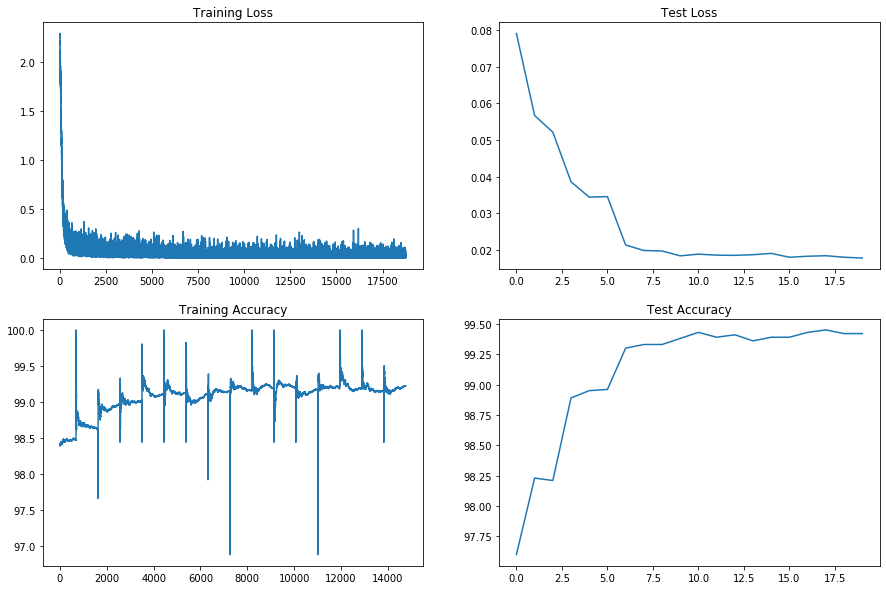

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Approach 4 -

Problem - Reduce overfitting and flucations in the test error/test accuracy
Solution - Use the different learning rate and slight data augmentation change parameter.

Used parameters - 9,678<br>
Human's based performance -99.7<br>
Maximum Train Accuracy Achieved -99.2<br>
Maximum Test Accuracy Achieved - 99.44<br>
Maximum - Epoch -20<br>
Consistency in result - 4 epoch<br>

Observtion - Fluctations reduced by the learning rate decay. From epoch 16 to 20, the consistency is greater than 99.4. According to the target, the results are lagging little bit. Trying to reach the target in next approach.
